# 1: Import required libraries and definition of global variables

In [1]:
#! pip install -r requirements.txt
#! pip install --force-reinstall -r requirements.txt

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import os
import glob
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from PIL import Image, ImageOps
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from ipywidgets import interact
from itertools import islice

# from dataset import MyData
# from model import Net
from make_gif_from_folder import make_gif

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(0)
print(device)

PATH_TO_PM_DATA = './data/pm_format'
PATH_TO_MARKUP_DATA = './data/CL_23.txt'
BOUND_THRASHOLD = 0.3

cuda:0


# 2: Model

## 2.1: Creating the model and dataset

#### 2.1.1: Dataset calss

In [2]:
class MyData(torch.utils.data.Dataset):
    def __init__(self, path_to_file, mode, mode_3d, radius, reduce_fctor=1, need_help=False, need_info=False):
        self.need_help = need_help
        self.mode_3d = mode_3d
        self.radius = radius
        self.maps_markup = self.make_markup()
        self.pm_list = self.get_pm_list()
        self.reduce_factor = reduce_fctor
        if mode == 'img':
            self.map_number = ''
            self.img_array = self.get_img_array(path_to_file) 
        elif mode == 'abz':
            self.map_number = path_to_file[-11:-7]
            self.img_array, self.help_array = self.read_from_abz(path_to_file)
        else:
            self.map_number = ''
            self.img_array = path_to_file
        
        self.width, self.height = self.img_array.shape
        self.total_pixel = self.width * self.height
        self.bound_length = len(np.where(self.img_array.reshape(-1, 1) < 255)[0])
        self.sign_mask = np.where((self._add_grad_label() * self.img_array).reshape(-1, 1) != 0)[0]
        
        self.mask = np.where(self.img_array.reshape(-1, 1) == 255)[0]
        self.bound_mask = np.where(self.img_array.reshape(-1, 1) < 255)[0]
        self.row_numbers = 1 * self.height

        self.data_2d, self.data_3d = self.make_data(mode_3d=self.mode_3d)
        self.data_3d.x, self.data_3d.y, self.data_3d.z = self.data_3d.T
        if need_info:
            print(f'width: {self.width}\n' +
                  f'height: {self.height}\n' +
                  f'total_pixel: {self.total_pixel}\n' +
                  f'bound length: {self.bound_length}\n' +
                  f'percent of bound pixels: {(100 * self.bound_length / self.total_pixel):.1f}%')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data_2d[idx], self.data_3d[idx]

    def get_img_array(self, path_to_file):
        return np.array(ImageOps.grayscale(Image.open(path_to_file))).astype(int)
        
    def get_pm_list(self):
        filenames = [filename for filename in glob.glob(f'{PATH_TO_PM_DATA}/*.dat')]
        pm_list = []
        for filename in filenames:
            with open(filename) as f:
                lines = [line[4:].replace('-1', '0').replace('+1', '1').rstrip() for line in f]
            pm_list.append(np.array([list(x) for x in lines], dtype = 'int'))
        return pm_list

    def _add_grad_label(self):
        tmp = self.img_array / self.img_array.max()

        left_shift, right_shift, up_shift, down_shift = np.ones((4, self.width, self.height))

        result = np.zeros(self.img_array.shape)

        left_shift[:, :-1] = tmp[:, 1:]
        right_shift[:, 1:] = tmp[:, :-1]
        up_shift[1:, :] = tmp[:-1, :]
        down_shift[:-1, :] = tmp[1:, :]

        result = left_shift + right_shift + down_shift + up_shift - 4 * tmp
        result = np.zeros(self.img_array.shape) != result
        return result.astype(int)

    def show_pm_list(self):
        plt.figure(figsize=(20, 30))
        maps_number = len(self.pm_list)
        for i in range(maps_number):
            plt.subplot(maps_number /  5, 5, i + 1) if maps_number % 5 == 0 else plt.subplot(maps_number // 5 + 1, 5, i + 1)
            plt.title(f'Map №{1904 + i}')
            plt.gca().axes.get_xaxis().set_visible(False)
            plt.gca().axes.get_yaxis().set_visible(False)
            plt.imshow(self.pm_list[i], cmap='gray')
        plt.show()
            
    def make_markup(self):
        res = {}
        current = 0
        with open(PATH_TO_MARKUP_DATA, 'r', encoding='windows-1251') as file:
            for line in file:
                try:
                    temp = list(map(int, line.rstrip().split()))
                except:
                    continue
                if len(temp) == 1:
                    current = temp[0]
                elif len(temp) == 0:
                    continue
                else:
                    if current not in res.keys():
                        res[current] = [temp[1:]] 
                    else:
                        res[current].append(temp[1:])
        return res
        
    def show_image(self):
        plt.figure(figsize=(10, 5))
        plt.title(f'Input Image №{self.map_number}')
        plt.imshow(self.img_array, cmap='gray', vmin=0, vmax=255)
    
    def read_from_abz(self, filename):
        with open(filename) as f:
            lines = [line.rstrip() for line in f]
        my_shape = [int(x) for x in lines[0].split()[-6:-4]]
        my_shape.reverse()
        width, height = my_shape[0], my_shape[1]
        img_array = np.full(shape=my_shape, fill_value=255)
        for line in lines[3:]:
            line = [int(x) for x in line.split()]
            if len(line) == 3:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                for i in range(x1, x2 + 1):
                    img_array[min(y, width - 1), min(i, height - 1)] = 0
            elif len(line) == 5:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                x3 = line[3]
                x4 = -line[4]
                for i in range(x1, x2 + 1):
                    img_array[min(y, width - 1), min(i, height - 1)] = 0
                for i in range(x3, x4 + 1):
                    img_array[min(y, width - 1), min(i, height - 1)] = 0
        if self.need_help:
            map_number = int(filename[-11:-7])
            i = 10
            help_array = np.full(shape=my_shape, fill_value=255)
            for line in self.maps_markup[map_number]:    
                for el in line:
                    x, y = int(el * (width - 1) / 180.), int(i * (height - 1) / 360.)
                    help_array[x, y] = 0
                    # help_array[min(x + 1, width - 1), y] = 0
                    # help_array[max(x - 1, 0), y] = 0
                    # help_array[x, min(y + 1, height - 1)] = 0
                    # help_array[x, max(y - 1, 0)] = 0
                i += 10
        return img_array, help_array if self.need_help else img_array

    def show_3d_static(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.data_3d.x, self.data_3d.y, self.data_3d.z, c=self.img_array.flatten())

    def show_3d(self):
        df = pd.DataFrame({'x': self.data_3d.x[::self.reduce_factor], 
                            'y': self.data_3d.y[::self.reduce_factor], 
                            'z': -self.data_3d.z[::self.reduce_factor], 
                            'label': self.img_array.flatten()[::self.reduce_factor]})
        return px.scatter_3d(df, x='x', y='y', z='z', color='label').update_traces(marker={'size': 2})
    
    def make_data(self, mode_3d):
        data_2d = torch.from_numpy(np.stack(np.indices((self.width, self.height)), axis=2).reshape(-1, 2)).float()
        x, y = data_2d.T
        x -= x.mean()
        x /= x.abs().max()
        y -= y.mean()
        y /= y.abs().max()
        data_2d = torch.stack((x, y), dim=1)
        match mode_3d:
            case 'sphere':
                z = x
                x = torch.cos(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
                y = torch.sin(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
                data_3d = self.radius * torch.stack((x, y, z), dim=1)
            case 'cylinder':
                x = torch.cos(torch.pi * data_2d[:, 1])
                y = torch.sin(torch.pi * data_2d[:, 1])
                z = data_2d[:, 0]
                data_3d = self.radius * torch.stack((x, y, z), dim=1)
            case _:
                print('Incorrect mode\n')
                raise SystemError(f'Incorrect mode: {mode_3d}\n')
        return data_2d, data_3d
    
    def read_from_abz(self, filename):
        with open(filename) as f:
            lines = [line.rstrip() for line in f]
        my_shape = [int(x) for x in lines[0].split()[-6:-4]]
        my_shape.reverse()
        width, height = my_shape[0], my_shape[1]
        img_array = np.full(shape=my_shape, fill_value=255)
        for line in lines[3:]:
            line = [int(x) for x in line.split()]
            if len(line) == 3:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                for i in range(x1, x2 + 1):
                    img_array[min(y, width - 1), min(i, height - 1)] = 0
            elif len(line) == 5:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                x3 = line[3]
                x4 = -line[4]
                for i in range(x1, x2 + 1):
                    img_array[min(y, width - 1), min(i, height - 1)] = 0
                for i in range(x3, x4 + 1):
                    img_array[min(y, width - 1), min(i, height - 1)] = 0
        if self.need_help:
            map_number = int(filename[-11:-7])
            i = 10
            help_array = np.full(shape=my_shape, fill_value=255)
            for line in self.maps_markup[map_number]:    
                for el in line:
                    x, y = int(el * (width - 1) / 180.), int(i * (height - 1) / 360.)
                    help_array[x, y] = 0
                    # help_array[min(x + 1, width - 1), y] = 0
                    # help_array[max(x - 1, 0), y] = 0
                    # help_array[x, min(y + 1, height - 1)] = 0
                    # help_array[x, max(y - 1, 0)] = 0
                i += 10
        return img_array, help_array if self.need_help else img_array

    def show_3d_static(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.data_3d.x, self.data_3d.y, self.data_3d.z, c=self.img_array.flatten())

    def show_3d(self):
        df = pd.DataFrame({'x': self.data_3d.x[::self.reduce_factor], 
                            'y': self.data_3d.y[::self.reduce_factor], 
                            'z': -self.data_3d.z[::self.reduce_factor], 
                            'label': self.img_array.flatten()[::self.reduce_factor]})
        return px.scatter_3d(df, x='x', y='y', z='z', color='label').update_traces(marker={'size': 2})
    
    def make_data(self, mode_3d):
        data_2d = torch.from_numpy(np.stack(np.indices((self.width, self.height)), axis=2).reshape(-1, 2)).float()
        x, y = data_2d.T
        x -= x.mean()
        x /= x.abs().max()
        y -= y.mean()
        y /= y.abs().max()
        data_2d = torch.stack((x, y), dim=1)
        match mode_3d:
            case 'sphere':
                z = x
                x = torch.cos(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
                y = torch.sin(torch.pi * y) * (1 - z.pow(2)).pow(0.5)
                data_3d = self.radius * torch.stack((x, y, z), dim=1)
            case 'cylinder':
                x = torch.cos(torch.pi * data_2d[:, 1])
                y = torch.sin(torch.pi * data_2d[:, 1])
                z = data_2d[:, 0]
                data_3d = self.radius * torch.stack((x, y, z), dim=1)
            case _:
                print('Incorrect mode\n')
                raise SystemError(f'Incorrect mode: {mode_3d}\n')
        return data_2d, data_3d


#### 2.1.2: Model class

In [3]:
class Net(nn.Module):
    __slots__ = 'dataset_list'
    def __init__(self, dataset_list, lr, weight_decay=1e-3):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 6), nn.ELU(),
            nn.Linear(6, 12), nn.ELU(),
            nn.Linear(12, 24), nn.ELU(),
            nn.Linear(24, 1), nn.Tanh())
        # self.weight = torch.nn.Parameter(torch.FloatTensor([1]), requires_grad=True)
        self.dataset_list = dataset_list
        self.data_list = [data.data_3d for data in self.dataset_list]
        self.lr = lr
        self.weight_decay = weight_decay
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=100)        
        self.loss_dict = {'loss': [],
                          'f_abs_integral': [],
                          'bound_integral': [],
                          'orientation_integral': [],
                          'f_integral': []}
                        #   'sign_integral': [],
                        #   'sign_integral_abs': []}
        
    def forward(self, x):
        #x = x.to(device)
        output = self.net(x)
        return output
    
    def compute_and_plot_gradient(self, input_list=None):
        batch_list = input_list if input_list is not None else self.data_list
        for batch in batch_list:
            batch.requires_grad_()
        tmp_list = [self(batch.to(device)) for batch in batch_list]
        for tmp in tmp_list:
            tmp.sum().backward()
        grad_out_list = [batch.grad.cpu() for batch in batch_list]
        grad_map_list = [((grad_out.pow(2).sum(dim=1)).pow(0.5)).view(dataset.img_array.shape) for grad_out, dataset in zip(grad_out_list, self.dataset_list)]
        plt.figure(figsize=(12, 6))
        for i, grad_map in enumerate(grad_map_list):
            plt.subplot(1, len(grad_map_list), i + 1)
            plt.title(r'Gradient map for $||\nabla f(x,y,z)||_2$' + f'\non input №{i + 1}', fontsize=15)
            plt.imshow(grad_map, cmap='plasma')
            plt.colorbar(location='bottom')
        return grad_out_list, grad_map_list

    def change_lr(self, lr):
        for g in self.optimizer.param_groups:
            g['lr'] = lr

    def show_loss_items(self):
        plt.figure(figsize=(12, 6))
        for i, (key, value) in islice(enumerate(self.loss_dict.items()), 1, len(self.loss_dict.keys())):
            plt.subplot(2, math.ceil((len(self.loss_dict.keys()) - 1) / 2), i)
            plt.xlabel('Epoch')
            plt.ylabel(key)
            plt.plot(value)  
        plt.show()

    def restart_model(self, lr, weight_decay=1e-3):
        model = Net(dataset_list=self.dataset_list, lr=lr, weight_decay=weight_decay)
        model.to(device)
        return model    

    def save_state_dict(self, path):
        torch.save(self.state_dict(), path)

    def show_3d(self, prediction_list, map_number):
        x, y, z = self.data_list[map_number].T
        df = pd.DataFrame({'x': x.cpu().detach().numpy(),
                            'y': y.cpu().detach().numpy(),
                            'z': -z.cpu().detach().numpy(),
                            'label': prediction_list[map_number].flatten()})
        return px.scatter_3d(df, x='x', y='y', z='z', color='label').update_traces(marker={'size': 2})

    def test_model(self, input_list, need_plot=False):
        with torch.no_grad():
            output_list = [self(input.to(device)).cpu().detach() for input in input_list]
        if need_plot:
            plt.figure(figsize=(12, 6))
            for i in range(len(output_list)):
                plt.subplot(1, len(output_list), i + 1)
                plt.title(f'Visualization of the function $f(x,y,z)$\n on input №{i + 1}')
                plt.imshow(output_list[i].view(self.dataset_list[i].img_array.shape), cmap='PuOr', vmin=-1, vmax=1) 
        return output_list

    def start_training(self, num_epochs, my_weight=1e-1, show_frequency=1e+2):
        for _, value in self.loss_dict.items():
            value.clear()
        batch_list = [data.to(device) for data in self.data_list]
        dir_path = 'epoch_outs'
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        for epoch in range(1, int(num_epochs) + 1):
            output_list = [self(batch) for batch in batch_list]
            self.optimizer.zero_grad()
            loss = self.compute_loss(output_list=output_list, my_weight=my_weight) 
            loss.backward(retain_graph=True)
            self.optimizer.step()
            if epoch % int(show_frequency) == 0 or epoch == num_epochs:
                output_list = [output.cpu().detach().view(dataset.img_array.shape) for output, dataset in zip(output_list, self.dataset_list)]
                clear_output(wait=True)
                gs = gridspec.GridSpec(2, len(self.dataset_list) + 1)
                fig = plt.figure(figsize=(16, 6))
                
                ax1 = fig.add_subplot(gs[:, 0])
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')
                ax1.plot(self.loss_dict['loss'])

                for i in range(1, len(output_list) + 1):
                    ax2 = fig.add_subplot(gs[0, i])
                    ax2.title.set_text(f'Prediction №{i}')
                    ax2.get_xaxis().set_ticks([])
                    ax2.get_yaxis().set_ticks([])
                    ax2.imshow(output_list[i - 1], cmap='PuOr', vmin=-1, vmax=1)

                    ax3 = fig.add_subplot(gs[1, i])
                    ax3.get_xaxis().set_ticks([])
                    ax3.get_yaxis().set_ticks([])
                    ax3.title.set_text(f'Input image №{i}')
                    ax3.imshow(self.dataset_list[i - 1].img_array, cmap='gray')

                plt.savefig(dir_path + '/epoch%06d.png' % epoch)
                plt.show()

    def compute_loss(self, output_list, my_weight): 
        loss, f_abs_integral, bound_integral, orientation_integral, f_integral = torch.zeros(len(self.loss_dict.items())) #, sign_integral, sign_integral_abs = torch.zeros(7)
        loss_, f_abs_integral_, bound_integral_, orientation_integral_, f_integral_ = torch.zeros(len(self.loss_dict.items())) #, sign_integral_, sign_integral_abs_ = torch.zeros(7)

        for (output, dataset) in zip(output_list, self.dataset_list):
            output = output.flatten()
            upper_bound = (output[:dataset.row_numbers].sum() / len(output[:dataset.row_numbers]) - 1).abs()
            lower_bound = (output[-dataset.row_numbers:].sum() / len(output[-dataset.row_numbers:]) + 1).abs()

            for key, _ in self.loss_dict.items():
                locals()[key + "_"] = locals()[key].clone()
            
            # bound_length_integral  = bound_length_integral_ + len(torch.masked_select(output, ~output.abs().ge(0.5))) / len(output)
            f_integral = f_integral_ + my_weight * output.sum().abs() / dataset.total_pixel
            # sign_integral = sign_integral_ + output[dataset.sign_mask].sum().abs() / len(dataset.sign_mask)
            # sign_integral_abs = sign_integral_abs_ + 1 - output[dataset.sign_mask].abs().sum() / len(dataset.sign_mask)
            orientation_integral = orientation_integral_ + 0.25 * (upper_bound + lower_bound)
            f_abs_integral = f_abs_integral_ + 1 - output[dataset.mask].abs().sum() / (dataset.total_pixel - dataset.bound_length) # хочу НЕ границу +-1
            bound_integral = bound_integral_ + (output[dataset.bound_mask].pow(2).sum() / dataset.bound_length) # хочу на границе 0
            loss = loss_ + f_abs_integral + bound_integral + orientation_integral + f_integral# + 0.1 * (sign_integral + sign_integral_abs)

        for key, _ in self.loss_dict.items():
            self.loss_dict[key].append(locals()[key].item())
            
        return loss
        # w_bound = torch.sigmoid(self.weight)
        # w_abs = 1 - w_bound
        # return (w_abs + 1) * f_abs_integral + (w_bound + 1) * bound_integral + orientation_integral, w_bound

## 2.2: Training and testing the model on different datasets

### 2.2.1: Single dataset list

#### 2.2.1.1: Definition of the dataset list

In [5]:
# dataset1=MyData(path_to_file='./data/sn1996k1906eng.abz', mode='1img', mode_3d='cylinder', radius=1, reduce_fctor=4, need_help=False)
# dataset2=MyData(path_to_file='./data/sn1996k1907eng.abz', mode='1img', mode_3d='cylinder', radius=1, reduce_fctor=4, need_help=False)
# dataset3=MyData(path_to_file='./data/sn1996k1908eng.abz', mode='1img', mode_3d='cylinder', radius=1, reduce_fctor=4, need_help=False)

# dataset_list = [dataset1, dataset2, dataset3]
dataset1 = MyData(path_to_file='./imgs/1904_low2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
# dataset2 = MyData(path_to_file='./data/sn1996k1905eng.abz', mode='abz', mode_3d='sphere', radius=2, reduce_fctor=1, need_help=False)

dataset_list = [dataset1] #, dataset2]

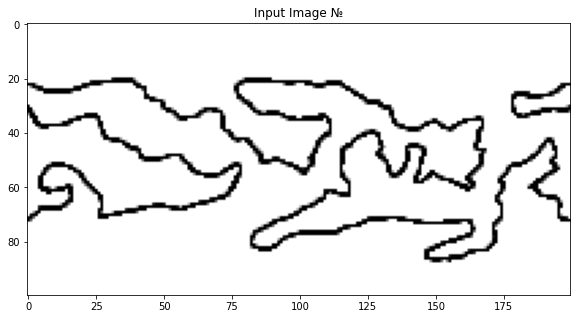

In [12]:
dataset1.show_image()

#### 2.2.1.2: Definition of the model

In [4]:
model = Net(dataset_list=dataset_list, lr=1e-3)
model.to(device)
# summary(model, input_size=(sum([len(x) for x in model.data_list]), 3))
# model.load_state_dict(torch.load('./3_cascade_1904.pt'))

NameError: name 'dataset_list' is not defined

#### 2.2.1.3: Show start state

In [ ]:
prediction_list = model.test_model(model.data_list, need_plot=True)

In [ ]:
model.show_3d(prediction_list=prediction_list, map_number=1)

#### 2.2.1.4: Training the model

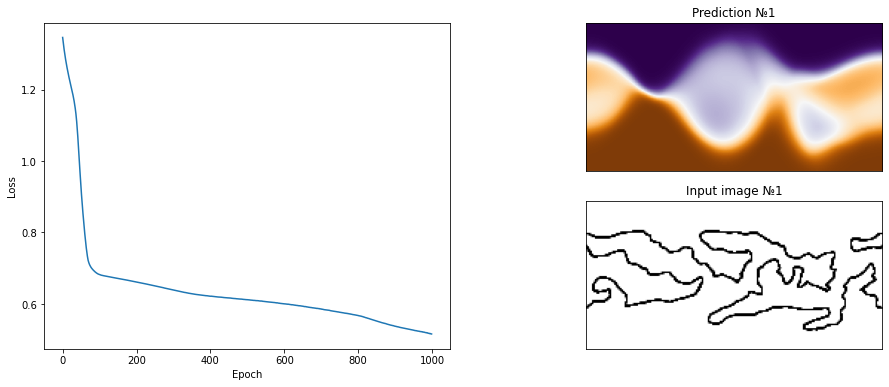

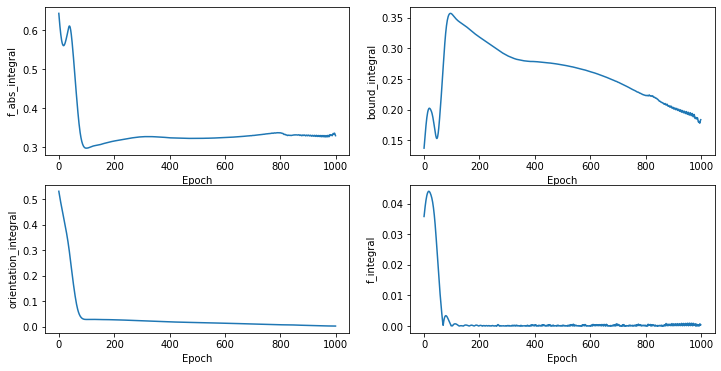

In [17]:
# model.change_lr(1e-3)
# model = model.restart_model(lr=1e-3)
model.start_training(num_epochs=1e+3, my_weight=0.1)
model.show_loss_items()

In [337]:
model.save_state_dict('')

In [ ]:
make_gif(dir_path='./epoch_outs', gifname='nice')

#### Testing the nodel

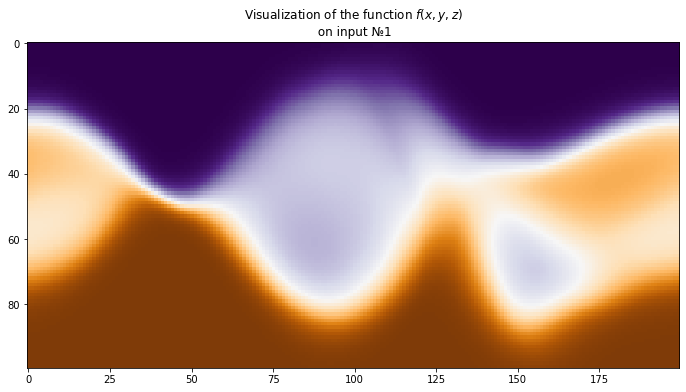

In [18]:
prediction_list = model.test_model(model.data_list, need_plot=True)

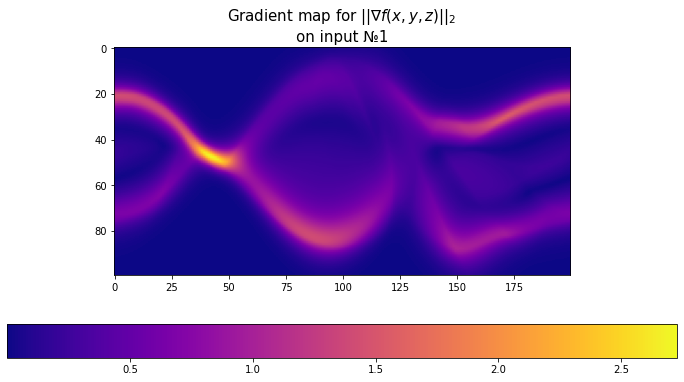

In [19]:
_, grad_map_list = model.compute_and_plot_gradient()

In [20]:
model.show_3d(prediction_list=prediction_list, map_number=0)

### 2.2.2: Map cascade

#### 2.2.2.1: Get image from abz

In [21]:
dataset1 = MyData(path_to_file='./imgs/1904_low2.png', mode='img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
# dataset2 = MyData(path_to_file='./data/sn1996k1905eng.abz', mode='abz', mode_3d='sphere', radius=2, reduce_fctor=1, need_help=False)

dataset_list = [dataset1] #, dataset2]

#### 2.2.2.2: Definition of the function that downscales the map

In [22]:
def downscale_map(input_arr, sq_size):
    width, height = input_arr.shape
    tmp_arr = input_arr.copy()
    if width % sq_size:
        tmp_arr = np.r_[input_arr, np.zeros((sq_size - width % sq_size, height))]
        width, height = tmp_arr.shape
    if height % sq_size:
        tmp_arr = np.c_[tmp_arr, np.zeros((sq_size - height % sq_size, width)).T]
        width, height = tmp_arr.shape
    result = np.array([np.hsplit(u, height / sq_size) for u in np.vsplit(tmp_arr, width / sq_size)]).reshape((-1, sq_size, sq_size))
    final_result = np.array([x.sum() for x in result]).reshape((width // sq_size, height // sq_size)) == 0
    return final_result

#### 2.2.2.3: Get map cascades from ''abz'' images

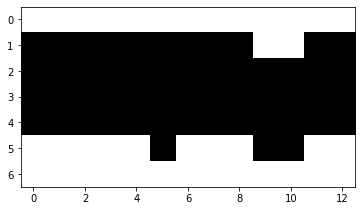

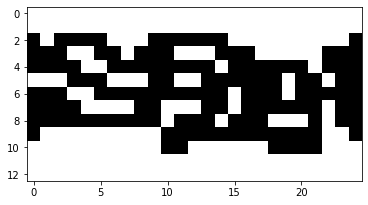

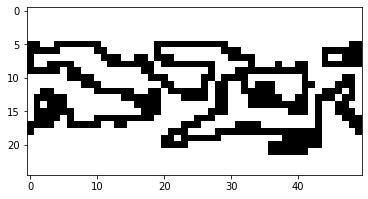

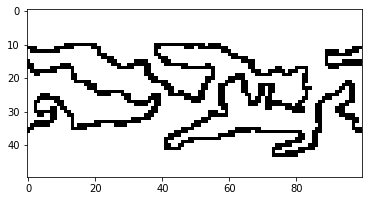

In [23]:
normal_img_array_1 = 1 - np.array(dataset1.img_array, dtype='float64') / 255.
map_cascade_1 = [split_map(normal_img_array_1, 2 ** x) for x in range(4, 0, -1)]

# convolve = np.vectorize(np.convolve, signature='(n),(m)->(k)')
# map_cascade = [(1 - convolve(convolve(normal_img_array, np.ones((i))).T, np.ones((i))).T) > 0 for i in range(200, 0, -50)]

for cas_map in map_cascade_1:
    plt.imshow(cas_map, cmap = "gray")
    plt.show()

In [ ]:
normal_img_array_2 = 1 - np.array(dataset2.img_array, dtype='float64') / 255.
map_cascade_2 = [split_map(normal_img_array_2, 2 ** x) for x in range(7, 3, -1)]

# convolve = np.vectorize(np.convolve, signature='(n),(m)->(k)')
# map_cascade = [(1 - convolve(convolve(normal_img_array, np.ones((i))).T, np.ones((i))).T) > 0 for i in range(200, 0, -50)]

for cas_map in map_cascade_2:
    plt.imshow(cas_map, cmap = "gray")
    plt.show()

#### 2.2.2.4: Training the model

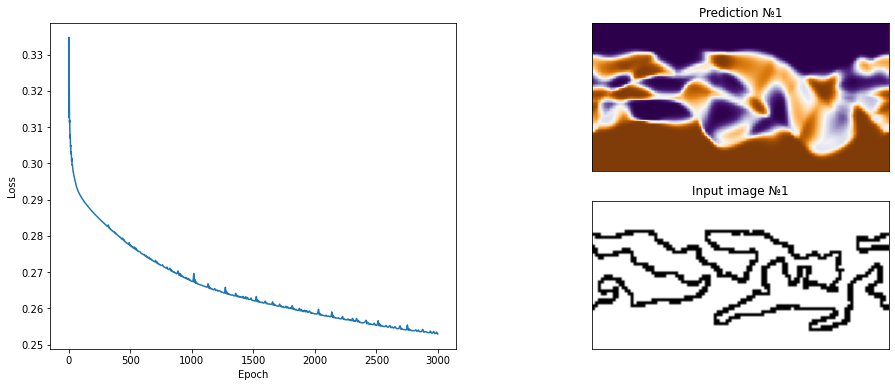

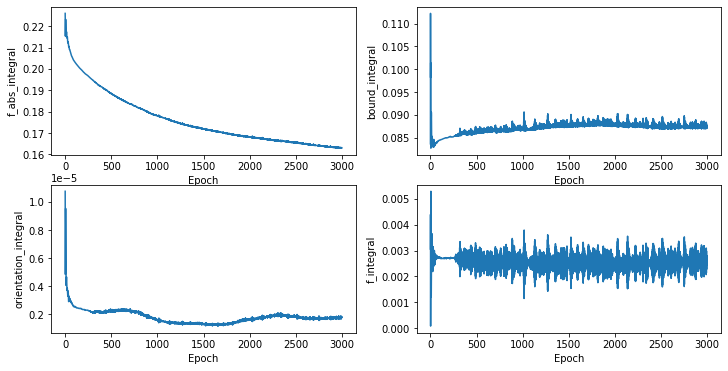

In [24]:
# for i, cas_map in enumerate(zip(map_cascade_1, map_cascade_2)):
#     dataset1 = MyData(path_to_file=255 * cas_map[0], mode='2img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)
#     dataset2 = MyData(path_to_file=255 * cas_map[1], mode='2img', mode_3d='cylinder', radius=2, reduce_fctor=1, need_help=False)

#     dataset_list = [dataset1, dataset2]
#     model = Net(dataset_list=dataset_list, lr=1e-3)
#     model.to(device)
#     # summary(model, input_size=(sum([len(x) for x in model.data_list]), 3))
#     if i:
#         model.load_state_dict(torch.load(f'./state_dcit/{i - 1}_cascade_1904.pt'))
#     _ = model.test_model(model.data_list, need_plot=True)
#     # dataset1.show_image()
#     model.start_training(num_epochs=3e+3, my_weight=0.1)
#     model.show_loss_items()
#     model.save_state_dict(f'./state_dcit/{i}_cascade_1904.pt')
#     input()

for i, cas_map in enumerate(map_cascade_1):
    dataset1 = MyData(path_to_file=255 * cas_map, mode='2img', mode_3d='cylinder', radius=5, reduce_fctor=1, need_help=False)


    dataset_list = [dataset1]
    model = Net(dataset_list=dataset_list, lr=1e-3)
    model.to(device)
    # summary(model, input_size=(sum([len(x) for x in model.data_list]), 3))
    if i:
        model.load_state_dict(torch.load(f'./state_dict/{i - 1}_cascade_1904.pt'))
    _ = model.test_model(model.data_list, need_plot=True)
    # dataset1.show_image()
    model.start_training(num_epochs=3e+3, my_weight=0.1)
    model.show_loss_items()
    model.save_state_dict(f'./state_dict/{i}_cascade_1904.pt')
    input()
    
    

### 2.2.3: Plot homotopy


In [ ]:
for i in torch.linspace(0, 1, steps=10):
    batch = i * dataset2.data_3d + (1 - i) * dataset1.data_3d 
    prediction = model.test_model(batch)
    plt.figure(figsize=(12, 6))
    plt.title(f'Visualization of the function $f(x,y,z)$ with $r={i * dataset2.radius + (1 - i) * dataset1.radius }$')
    plt.imshow(prediction.view(dataset1.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)

# 3: Loss parameters optimization

## Neural network approach

### Preproccessing

#### Definition of the splitting map function

In [138]:
def split_map(path, need_plot=False):

    img = np.array(ImageOps.grayscale(Image.open(path))).astype(int)
    width, height = img.shape
    
    if need_plot:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')

    x_parts = height // 10
    y_parts = width // 5
    delta = int(y_parts // 2.5)

    for x in range(x_parts // 2, width, x_parts):
        for y in range(y_parts // 2, height, y_parts):
            img[x-delta:x+delta, y-delta:y+delta] = 255
    if need_plot:
        plt.subplot(1, 2, 2)
        plt.imshow(img, cmap='gray')
        print(f'x_parts = {x_parts}\ny_parts = {y_parts}\ndelta = {delta}')

x_parts = 120
y_parts = 120
delta = 48


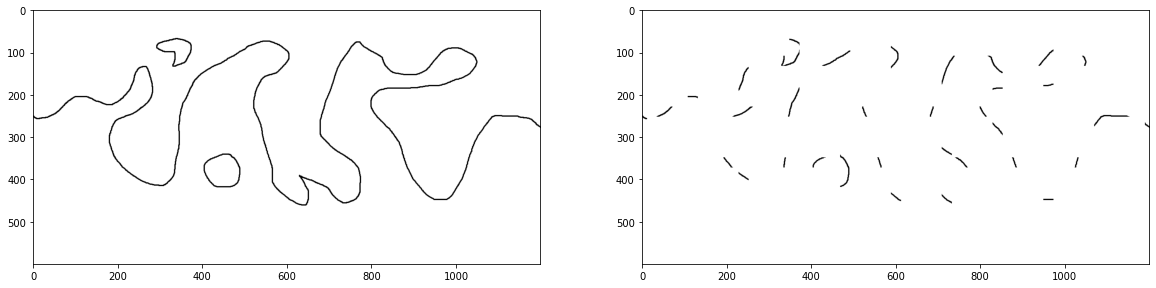

In [139]:
split_map(path='./imgs/target/2.png', need_plot=True)


### Model class

In [5]:
class LossNet(nn.Module):
    def __init__(self):#, dataset_list, lr, weight_decay=1e-3):
        super(LossNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 5), nn.ELU(),
            nn.Linear(5, 6), nn.ELU(),
            nn.Linear(6, 5), nn.ELU(),
            nn.Linear(5, 3), nn.Softmax(dim=0))
        # self.weight = torch.nn.Parameter(torch.FloatTensor([1]), requires_grad=True)
        self.loss_dict = {'loss': [],
                    'f_abs_integral': [],
                    'bound_integral': [],
                    'orientation_integral': [],
                    'f_integral': []}
    def forward(self, x):
        #x = x.to(device)
        output = self.net(x)
        return output

    def start_training(self, dataset):
        batch = dataset.img_list
        input = torch.Tensor((1, 1, 1, 1))
        loss = 

    def compute_loss(self, dataset, out_weights):
        loss, f_abs_integral, bound_integral, orientation_integral, f_integral = torch.zeros(len(self.loss_dict.items())) #, sign_integral, sign_integral_abs = torch.zeros(7)
        loss_, f_abs_integral_, bound_integral_, orientation_integral_, f_integral_ = torch.zeros(len(self.loss_dict.items())) #, sign_integral_, sign_integral_abs_ = torch.zeros(7)

        f_abs_integral_weight, bound_integral_weight, f_integral_weight = out_weights

        # f_integral_weight = 1. / dataset[i].total_pixel
        # bound_integral_weight = 1. / dataset[i].bound_length
        # f_abs_integral_weight = 1. / (dataset[i].total_pixel - dataset[i].bound_length) 

        for i, data in enumerate(dataset.img_list):
            data = data.flatten()
            upper_bound = (data[:dataset[i].row_numbers].sum() / len(data[:dataset[i].row_numbers]) - 1).abs()
            lower_bound = (data[-dataset[i].row_numbers:].sum() / len(data[-dataset[i].row_numbers:]) + 1).abs()

            for key, _ in self.loss_dict.items():
                locals()[key + "_"] = locals()[key].clone()
            
            # bound_length_integral  = bound_length_integral_ + len(torch.masked_select(output, ~output.abs().ge(0.5))) / len(output)
            f_integral = f_integral_ + f_integral_weight * data.sum().abs() 
            # sign_integral = sign_integral_ + output[dataset.sign_mask].sum().abs() / len(dataset.sign_mask)
            # sign_integral_abs = sign_integral_abs_ + 1 - output[dataset.sign_mask].abs().sum() / len(dataset.sign_mask)
            orientation_integral = orientation_integral_ + 0.25 * (upper_bound + lower_bound)
            f_abs_integral = f_abs_integral_ + 1 - f_abs_integral_weight * data[dataset[i].mask].abs().sum() # хочу НЕ границу +-1
            bound_integral = bound_integral_ + bound_integral_weight * data[dataset[i].bound_mask].pow(2).sum() # хочу на границе 0
            loss = loss_ + f_abs_integral + bound_integral + orientation_integral + f_integral# + 0.1 * (sign_integral + sign_integral_abs)

        for key, _ in self.loss_dict.items():
            self.loss_dict[key].append(locals()[key].item())
            
        return loss

SyntaxError: invalid syntax (1111662484.py, line 21)

In [16]:
net = LossNet()

In [18]:
out = net(torch.Tensor((1, 2, 3, 4)))
print(out, out.sum())

tensor([0.2206, 0.2438, 0.1230, 0.4126], grad_fn=<SoftmaxBackward0>) tensor(1.0000, grad_fn=<SumBackward0>)


In [ ]:


    def start_training(self, num_epochs, my_weight=1e-1, show_frequency=1e+2):
        for _, value in self.loss_dict.items():
            value.clear()
        batch_list = [data.to(device) for data in self.data_list]
        dir_path = 'epoch_outs'
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        for epoch in range(1, int(num_epochs) + 1):
            output_list = [self(batch) for batch in batch_list]
            self.optimizer.zero_grad()
            loss = self.compute_loss(output_list=output_list, my_weight=my_weight) 
            loss.backward(retain_graph=True)
            self.optimizer.step()
            if epoch % int(show_frequency) == 0 or epoch == num_epochs:
                output_list = [output.cpu().detach().view(dataset.img_array.shape) for output, dataset in zip(output_list, self.dataset_list)]
                clear_output(wait=True)
                gs = gridspec.GridSpec(2, len(self.dataset_list) + 1)
                fig = plt.figure(figsize=(16, 6))
                
                ax1 = fig.add_subplot(gs[:, 0])
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')
                ax1.plot(self.loss_dict['loss'])

                for i in range(1, len(output_list) + 1):
                    ax2 = fig.add_subplot(gs[0, i])
                    ax2.title.set_text(f'Prediction №{i}')
                    ax2.get_xaxis().set_ticks([])
                    ax2.get_yaxis().set_ticks([])
                    ax2.imshow(output_list[i - 1], cmap='PuOr', vmin=-1, vmax=1)

                    ax3 = fig.add_subplot(gs[1, i])
                    ax3.get_xaxis().set_ticks([])
                    ax3.get_yaxis().set_ticks([])
                    ax3.title.set_text(f'Input image №{i}')
                    ax3.imshow(self.dataset_list[i - 1].img_array, cmap='gray')

                plt.savefig(dir_path + '/epoch%06d.png' % epoch)
                plt.show()

    def compute_loss(self, output_list, my_weight): 
        loss, f_abs_integral, bound_integral, orientation_integral, f_integral = torch.zeros(len(self.loss_dict.items())) #, sign_integral, sign_integral_abs = torch.zeros(7)
        loss_, f_abs_integral_, bound_integral_, orientation_integral_, f_integral_ = torch.zeros(len(self.loss_dict.items())) #, sign_integral_, sign_integral_abs_ = torch.zeros(7)

        for (output, dataset) in zip(output_list, self.dataset_list):
            output = output.flatten()
            upper_bound = (output[:dataset.row_numbers].sum() / len(output[:dataset.row_numbers]) - 1).abs()
            lower_bound = (output[-dataset.row_numbers:].sum() / len(output[-dataset.row_numbers:]) + 1).abs()

            for key, _ in self.loss_dict.items():
                locals()[key + "_"] = locals()[key].clone()
            
            # bound_length_integral  = bound_length_integral_ + len(torch.masked_select(output, ~output.abs().ge(0.5))) / len(output)
            f_integral = f_integral_ + my_weight * output.sum().abs() / dataset.total_pixel
            # sign_integral = sign_integral_ + output[dataset.sign_mask].sum().abs() / len(dataset.sign_mask)
            # sign_integral_abs = sign_integral_abs_ + 1 - output[dataset.sign_mask].abs().sum() / len(dataset.sign_mask)
            orientation_integral = orientation_integral_ + 0.25 * (upper_bound + lower_bound)
            f_abs_integral = f_abs_integral_ + 1 - output[dataset.mask].abs().sum() / (dataset.total_pixel - dataset.bound_length) # хочу НЕ границу +-1
            bound_integral = bound_integral_ + (output[dataset.bound_mask].pow(2).sum() / dataset.bound_length) # хочу на границе 0
            loss = loss_ + f_abs_integral + bound_integral + orientation_integral + f_integral# + 0.1 * (sign_integral + sign_integral_abs)

        for key, _ in self.loss_dict.items():
            self.loss_dict[key].append(locals()[key].item())
            
        return loss
        # w_bound = torch.sigmoid(self.weight)
        # w_abs = 1 - w_bound
        # return (w_abs + 1) * f_abs_integral + (w_bound + 1) * bound_integral + orientation_integral, w_bound

## Analitycally approach

#### The loss function depends on the integrals $I_i$ and the corresponding weights $w_i$ and is of the form $$\mathcal{L} = \text{Loss}(w_1, \ldots, w_n, I_1, \ldots, I_n) = \sum_1^n w_i \times I_i$$ But $I_i$ does not depend on the weights $w_i$. Therefore, $\frac{\partial\mathcal{L}}{\partial w_i} = I_i$. It means that the loss function has no singular points.

## Graphical approach

### Dataset class

In [3]:
class InputImagesInfo(torch.utils.data.Dataset):
    def __init__(self, path_to_inputs, path_to_targets):
        self.info_dict = {'img_list': [],
                            'width_list': [],
                            'height_list': [],
                            'total_pixel_list': [],
                            'bound_length_list': [],
                            'mask_list': [],
                            'bound_mask_list': [],
                            'row_numbers_list': [],}
        for (input_path, target_path) in zip(path_to_inputs, path_to_targets):
            img = np.array(ImageOps.grayscale(Image.open(input_path))).astype(int)
            
            width, height = img.shape
            total_pixel = width * height
            bound_length = len(np.where(img.reshape(-1, 1) < 255)[0])
            
            mask = np.where(img.reshape(-1, 1) == 255)[0]
            bound_mask = np.where(img.reshape(-1, 1) < 255)[0]
            row_numbers = 1 * height
            
            img = np.array(ImageOps.grayscale(Image.open(target_path))).astype(int)
            img[img == 90] = -1
            img[img == 190] = 1
            img = torch.from_numpy(img)

            for key in self.info_dict.keys():
                self.info_dict[key].append(locals()[key[:-5]])

    def __len__(self):
        return len(self.info_dict['img_list'])

    def __getitem__(self, idx):
        return [value[idx] for value in self.info_dict.values()]

In [4]:
batch = InputImagesInfo(path_to_inputs=['./imgs/input/1.png'],
                         path_to_targets=['./imgs/target/1.png'])

1


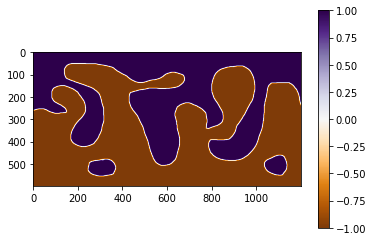

In [5]:
print(len(batch))
plt.imshow(batch[0][0], cmap='PuOr')
plt.colorbar()

### Calculating of the integrals in loss which are not dependent on the weights

In [6]:
loss, f_abs_integral, bound_integral, orientation_integral, f_integral = torch.zeros(5)
integrals_dict = {'f_abs_integral': [],
                    'bound_integral': [],
                    'f_integral': []}

for img, width, height, total_pixel, bound_length, mask, bound_mask, row_numbers in batch:
    img = img.flatten()
    
    f_integral = img.sum().abs() / total_pixel
    f_abs_integral = 1 - img[mask].abs().sum() / (total_pixel - bound_length) # хочу НЕ границу +-1
    bound_integral = img[bound_mask].pow(2).sum() / bound_length # хочу на границе 0

    for key in integrals_dict.keys():
        integrals_dict[key].append(locals()[key])
        

In [7]:
integrals_dict

{'f_abs_integral': [tensor(0.0133)],
 'bound_integral': [tensor(9.7362e-05)],
 'f_integral': [tensor(0.1624)]}

In [27]:
def compute_loss(weights_list): 
    f_integral_weight, f_abs_integral_weight, bound_integral_weight = weights_list
    # print(f_integral_weight, f_abs_integral_weight, bound_integral_weight)
    # f_abs_integral_weight = 0
    local_vars = locals()
    # print(locals()[key+'_weight'])
    res = sum([sum(local_vars[key+'_weight'] * np.array(integrals_dict[key])) for key in integrals_dict.keys()])
    return res
    # return f_integral_weight*sum(integrals_dict['f_integral']) + f_abs_integral_weight*sum(integrals_dict['f_abs_integral']) + bound_integral_weight*sum(integrals_dict['bound_integral'])

### Tests

#### Interactive

In [30]:
@interact(f_integral_weight=(0, 10, 0.01), f_abs_integral_weight=(0, 10, 0.01), bound_integral_weight=(0, 10, 0.01))
def get_result(f_integral_weight=1., f_abs_integral_weight=1., bound_integral_weight=1.):
    w1, w2, w3 = f_integral_weight, f_abs_integral_weight, bound_integral_weight
    print("loss(f_integral_weight={}, f_abs_integral_weight={}, bound_integral_weight={}) is {}".format(w1, w2, w3, compute_loss([w1,w2,w3])))

interactive(children=(FloatSlider(value=1.0, description='f_integral_weight', max=10.0, step=0.01), FloatSlide…

In [29]:
get_result()

loss(f_integral_weight=1.0, f_abs_integral_weight=1.0, bound_integral_weight=1.0) is 0.17573673754668562


In [13]:
@interact(x=(0, 10, .1))
def f(x=10):
    xx = np.linspace(-2, 2, 101)
    plt.plot(xx, x * xx)
    plt.ylim(-2, 2)


interactive(children=(FloatSlider(value=10.0, description='x', max=10.0), Output()), _dom_classes=('widget-int…

#### 2D map

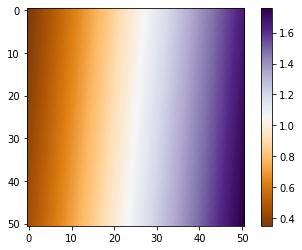

In [32]:
x = y = np.linspace(2, 10, 51)
z = np.array([compute_loss([i, j, 1]) for j in y for i in x])
Z = z.reshape(51, 51)
plt.imshow(Z, interpolation='bilinear', cmap='PuOr')
plt.colorbar()
plt.show()

# 4: Given data research

In [ ]:
dataset1.show_pm_list()

In [5]:
a = [(el-0.5).sum() for el in dataset1.pm_list]

In [ ]:
a

In [ ]:
with open('./data/sn1996k1904eng.abz') as f:
    lines = [line.rstrip() for line in f]
    my_shape = [int(x) for x in lines[0].split()[-6:-4]]
    my_shape.reverse()
    width, height = my_shape[0], my_shape[1]
    img_array = np.full(shape=my_shape, fill_value=255)
    for line in lines[3:]:
        line = [int(x) for x in line.split()]
        if len(line) == 3:
            y = line[0]
            x1 = line[1]
            x2 = -line[2]
            for i in range(x1, x2 + 1):
                img_array[min(y, width - 1), min(i, height - 1)] = 0
        elif len(line) == 5:
            y = line[0]
            x1 = line[1]
            x2 = -line[2]
            x3 = line[3]
            x4 = -line[4]
            for i in range(x1, x2 + 1):
                img_array[min(y, width - 1), min(i, height - 1)] = 0
            for i in range(x3, x4 + 1):
                img_array[min(y, width - 1), min(i, height - 1)] = 0
        elif len(line) > 6:
            vol_number = line[0]
            plt.imshow(img_array, cmap='gray')
            plt.title(f'{vol_number}')
            plt.show()
            
    

In [ ]:
plt.imshow(img_array, cmap='gray')

In [11]:
out_list = [dataset1.img_array.reshape(-1, 1) / 255]

In [12]:
out_list

[array([[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]])]

In [13]:
dataset1.img_array.reshape(-1, 1) / 255

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [6]:
img = np.array(ImageOps.grayscale(Image.open('./color_script/1.png'))).astype(int)

In [7]:
img[img == 90] = -1
img[img == 190] = 1

In [8]:
img

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [9]:
model.compute_loss([torch.from_numpy(img).view(-1, 1)], my_weight=0.1)

NameError: name 'model' is not defined

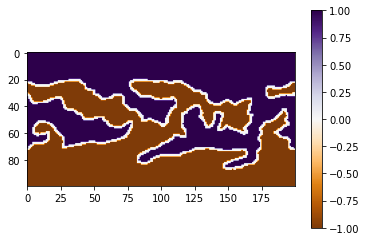

In [43]:
plt.imshow(img, cmap='PuOr')
plt.colorbar()

# 5: Closed curves

In [246]:
def plot_closed_curve(points_number = 10):
    rho = torch.rand(points_number) * torch.logspace(-0.5, -2.5, points_number)
    phi = 2 * torch.pi * torch.rand(points_number)
    t = torch.linspace(0, 2 * torch.pi, 20)
    r = torch.ones(len(t))
    for h in range(points_number):
        r += rho[h] * torch.sin(h * t + phi[h])
    x, y = r * torch.sin(t), r * torch.cos(t)
    plt.figure(figsize=(18, 9))
    plt.subplot(1, 2, 1)
    plt.plot(t, r, t, r, 'x')
    plt.xlabel('t, radians')
    plt.ylabel('r(t)')
    plt.subplot(1, 2, 2)
    plt.plot(x, y, x, y, 'x')
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')


In [ ]:
plot_closed_curve(50)

Text(0, 0.5, 'y(t)')

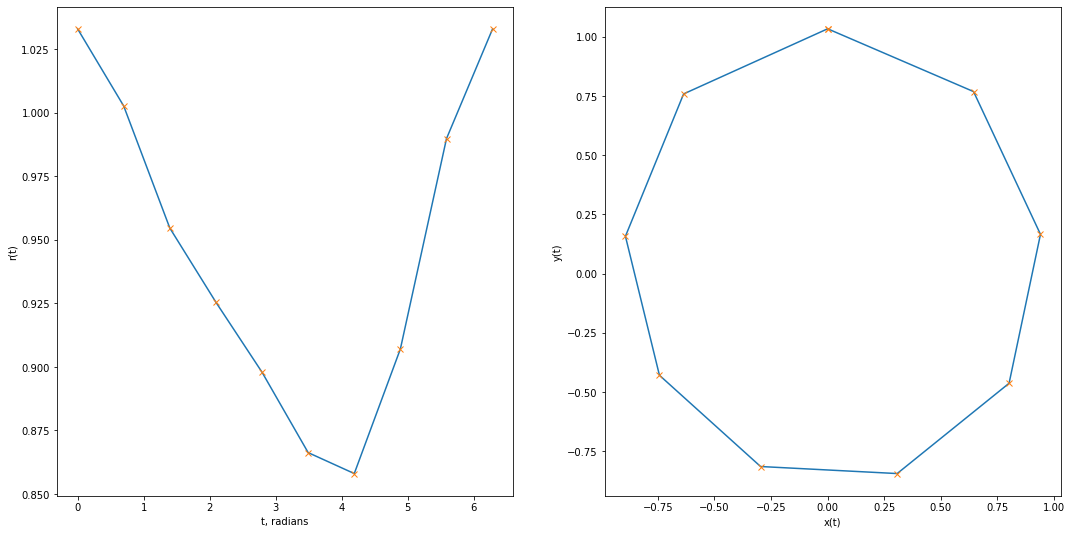

In [26]:
points_number = 5
rho = torch.rand(points_number) * torch.logspace(-0.5, -2.5, points_number)
phi = 2 * torch.pi * torch.rand(points_number)
t = torch.linspace(0, 2 * torch.pi, 10)
r = torch.ones(len(t))
for h in range(points_number):
    r += rho[h] * torch.sin(h * t + phi[h])
x, y = r * torch.sin(t), r * torch.cos(t)
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(t, r, t, r, 'x')
plt.xlabel('t, radians')
plt.ylabel('r(t)')
plt.subplot(1, 2, 2)
plt.plot(x, y, x, y, 'x')
plt.xlabel('x(t)')
plt.ylabel('y(t)')

In [19]:
H = 10
rho = np.random.rand(H)*np.logspace(-0.5,-2.5,H)
phi = np.random.rand(H)* 2*np.pi

t = np.linspace(0,2*np.pi,101)
r = np.ones(len(t))
for h in range(H):
    r = r + rho[h]*np.sin(h*t+phi[h])
x = r * np.cos(t)
y = r * np.sin(t)

Text(0, 0.5, 'y(t)')

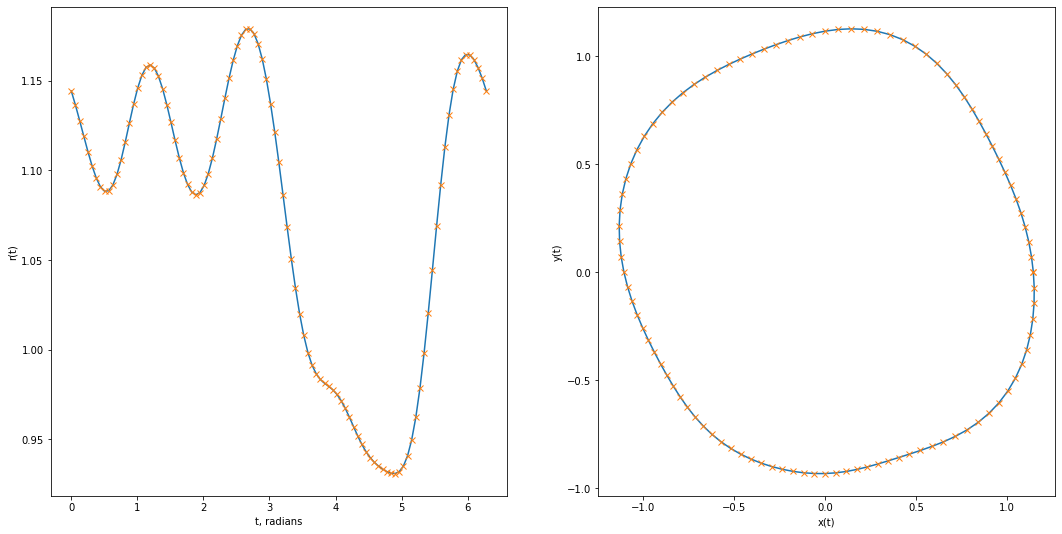

In [20]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(t, r, t, r, 'x')
plt.xlabel('t, radians')
plt.ylabel('r(t)')
plt.subplot(1, 2, 2)
plt.plot(x, y, x, y, 'x')
plt.xlabel('x(t)')
plt.ylabel('y(t)')